In [1]:
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data load

## Train

In [2]:
train_df = pd.read_csv('../dat/train.csv')
print(train_df.shape)


(1460, 81)


# Features correlations to target

Find most important features relative to target
SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   

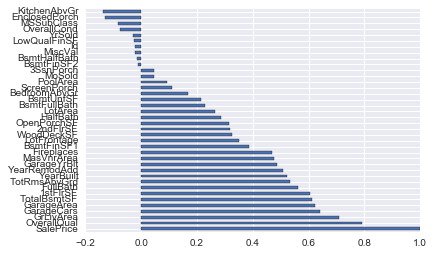

In [3]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train_df.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)
corr.SalePrice.plot(kind = "barh")
#corr.hist()
#sns.heatmap(corr)

# Target

In [4]:
y_ = train_df.SalePrice

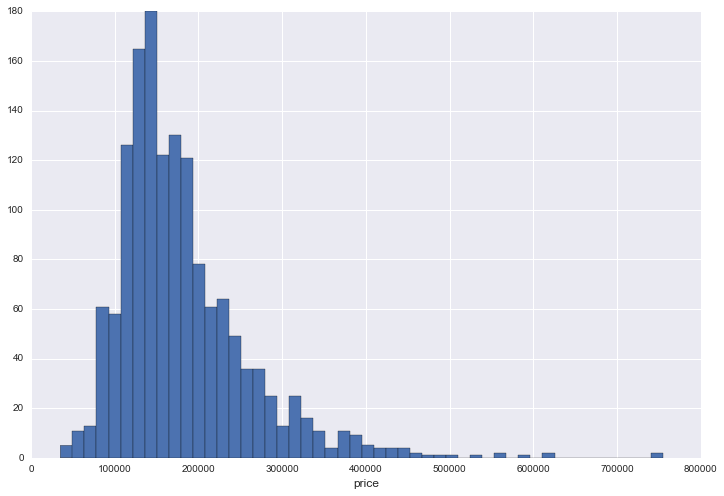

In [5]:
# Hist
plt.figure(figsize=(12,8))
#sns.distplot(train_df.price.values, bins=50, kde=False)
y_.hist(bins=50)
plt.xlabel('price', fontsize=12)
plt.show()

Note how the price is skewed. 

In [6]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
print(skew(y_)) # >0.5


1.880940746034036


In [7]:
y_ = train_df.SalePrice
y = y_log = np.log1p(y_)
train_df = train_df.drop('SalePrice', axis=1)
train_idx = len(train_df)

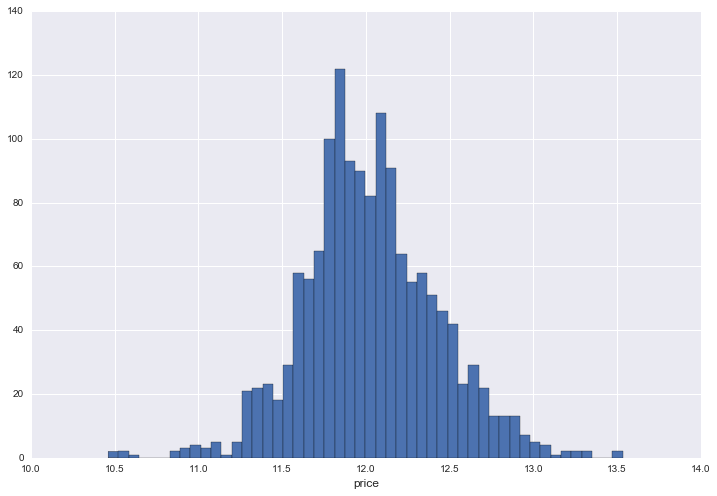

In [8]:
# Hist log(price)
import numpy as np
plt.figure(figsize=(12,8))
# log(price + 1) to avoid 0's
#sns.distplot(np.log(train_df.price + 1).values, bins=50, kde=False)
# Same as:
#sns.distplot(np.log(train_df['price'] + 1).values, bins=50, kde=False)
# Same as :
#np.log(train_df.price + 1).hist(bins=50)
# Same as:
y_log.hist(bins=50)
plt.xlabel('price', fontsize=12)
plt.show()

In [9]:
print(skew(y_log)) # <0.5

0.12122191311528363


## Test

In [10]:
test_df = pd.read_csv('../dat/test.csv')
print(test_df.shape)
len(test_df.columns) == len(train_df.columns)

(1459, 80)


True

## Merge/Concat

In [11]:
df = pd.concat([train_df, test_df], axis=0)
df.shape

(2919, 80)

# Handle missing vals

In [12]:
# Number of colomns with nulls
def check_nulls(df):
    print(df.isnull().sum())
    return len(df.isnull().sum().nonzero()[0])

In [13]:
print(check_nulls(df))

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
TotRmsAbvGrd        0
Functional          2
Fireplaces          0
FireplaceQu      1420
GarageType        157
GarageYrBlt       159
GarageFinish      159
GarageCars          1
GarageArea          1
GarageQual        159
GarageCond

## Special colomns handling

Handle missing values for features where median/mean or most common value doesn't make sense

In [14]:


# Alley : data description says NA means "no alley access"
df.loc[:, "Alley"] = df.loc[:, "Alley"].fillna("NA")
# BedroomAbvGr : NA most likely means 0
df.loc[:, "BedroomAbvGr"] = df.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
df.loc[:, "BsmtQual"] = df.loc[:, "BsmtQual"].fillna("No")
df.loc[:, "BsmtCond"] = df.loc[:, "BsmtCond"].fillna("No")
df.loc[:, "BsmtExposure"] = df.loc[:, "BsmtExposure"].fillna("No")
df.loc[:, "BsmtFinType1"] = df.loc[:, "BsmtFinType1"].fillna("No")
df.loc[:, "BsmtFinType2"] = df.loc[:, "BsmtFinType2"].fillna("No")
df.loc[:, "BsmtFullBath"] = df.loc[:, "BsmtFullBath"].fillna(0)
df.loc[:, "BsmtHalfBath"] = df.loc[:, "BsmtHalfBath"].fillna(0)
df.loc[:, "BsmtUnfSF"] = df.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
df.loc[:, "CentralAir"] = df.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
df.loc[:, "Condition1"] = df.loc[:, "Condition1"].fillna("Norm")
df.loc[:, "Condition2"] = df.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
df.loc[:, "EnclosedPorch"] = df.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
df.loc[:, "ExterCond"] = df.loc[:, "ExterCond"].fillna("TA")
df.loc[:, "ExterQual"] = df.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
df.loc[:, "Fence"] = df.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
df.loc[:, "FireplaceQu"] = df.loc[:, "FireplaceQu"].fillna("No")
df.loc[:, "Fireplaces"] = df.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
df.loc[:, "Functional"] = df.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
df.loc[:, "GarageType"] = df.loc[:, "GarageType"].fillna("No")
df.loc[:, "GarageFinish"] = df.loc[:, "GarageFinish"].fillna("No")
df.loc[:, "GarageQual"] = df.loc[:, "GarageQual"].fillna("No")
df.loc[:, "GarageCond"] = df.loc[:, "GarageCond"].fillna("No")
df.loc[:, "GarageArea"] = df.loc[:, "GarageArea"].fillna(0)
df.loc[:, "GarageCars"] = df.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
df.loc[:, "HalfBath"] = df.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
df.loc[:, "HeatingQC"] = df.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
df.loc[:, "KitchenAbvGr"] = df.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
df.loc[:, "KitchenQual"] = df.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
df.loc[:, "LotFrontage"] = df.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
df.loc[:, "LotShape"] = df.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
df.loc[:, "MasVnrType"] = df.loc[:, "MasVnrType"].fillna("None")
df.loc[:, "MasVnrArea"] = df.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
df.loc[:, "MiscFeature"] = df.loc[:, "MiscFeature"].fillna("No")
df.loc[:, "MiscVal"] = df.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
df.loc[:, "OpenPorchSF"] = df.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
df.loc[:, "PavedDrive"] = df.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
df.loc[:, "PoolQC"] = df.loc[:, "PoolQC"].fillna("No")
df.loc[:, "PoolArea"] = df.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
df.loc[:, "SaleCondition"] = df.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
df.loc[:, "ScreenPorch"] = df.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
df.loc[:, "TotRmsAbvGrd"] = df.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
df.loc[:, "Utilities"] = df.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
df.loc[:, "WoodDeckSF"] = df.loc[:, "WoodDeckSF"].fillna(0)
# LandSlope : Most likely NA means Mod
df.loc[:, "LandSlope"] = df.loc[:, "LandSlope"].fillna("Mod")
# Street : Most likely NaN means Pave
df.loc[:, "Street"] = df.loc[:, "Street"].fillna("Pave")

# Ordinal values

Encode some categorical features as ordered numbers when there is information in the order.



## Case 1: Ordinals as numerical features

In this setting, we will replace all the ordinal values with numerical ones. 

They will be scaled normally later.

Now, for the sprecially handled missing values, (like None or No), these need to be given an ordinal number as well. Otherwise, the None or No will be counted as strings and the whole var is counted as object, and hence will be handled with OHE+embedding



In [15]:

df = df.replace({"Alley" : {"NA" : 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 0, "Fa" : 1, "TA": 2, "Gd": 3, "Ex" : 4},
                       "ExterQual" : {"Po" : 0, "Fa" : 1, "TA": 2, "Gd": 3, "Ex" : 4},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 0, "Sev" : 1, "Maj2" : 2, "Maj1" : 3, "Mod": 4, 
                                       "Min2" : 5, "Min1" : 6, "Typ" : 7},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "KitchenQual" : {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "LandSlope" : {"Sev" : 0, "Mod" : 1, "Gtl" : 2},
                       "LotShape" : {"IR3" : 0, "IR2" : 1, "IR1" : 2, "Reg" : 3},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 0, "Pave" : 1},
                       "Utilities" : {"ELO" : 0, "NoSeWa" : 1, "NoSewr" : 2, "AllPub" : 3}}
                     )

In [16]:
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,1,0,3,Lvl,3,...,0,0,0,No,No,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,1,0,3,Lvl,3,...,0,0,0,No,No,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,1,0,2,Lvl,3,...,0,0,0,No,No,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,1,0,2,Lvl,3,...,0,0,0,No,No,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,1,0,2,Lvl,3,...,0,0,0,No,No,0,12,2008,WD,Normal


In [17]:
#ordinal_cols = ["Alley", "BedroomAbvGr", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "BsmtFullBath", "BsmtHalfBath", "BsmtUnfSF", "CentralAir", "Condition1", "Condition2", "EnclosedPorch", "ExterCond", "ExterQual", "Fence", "FireplaceQu", "Fireplaces", "Functional", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "GarageArea", "GarageCars", "HalfBath", "HeatingQC", "KitchenAbvGr", "KitchenQual", "LotFrontage", "LotShape", "MasVnrType", "MasVnrArea", "MiscFeature", "MiscVal", "OpenPorchSF", "PavedDrive", "PoolQC", "PoolArea", "SaleCondition", "ScreenPorch", "TotRmsAbvGrd", "Utilities", "WoodDeckSF", "Street", "LandSlope"]
ordinal_cols = ["Alley", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "BsmtQual", "ExterCond", "ExterQual", "FireplaceQu", "Functional", "GarageCond", "GarageQual", "HeatingQC", "KitchenQual", "LandSlope", "LotShape", "PavedDrive", "PoolQC", "Street", "Utilities"]
print(df[ordinal_cols].dtypes)
df[ordinal_cols].head(3)

Alley           int64
BsmtCond        int64
BsmtExposure    int64
BsmtFinType1    int64
BsmtFinType2    int64
BsmtQual        int64
ExterCond       int64
ExterQual       int64
FireplaceQu     int64
Functional      int64
GarageCond      int64
GarageQual      int64
HeatingQC       int64
KitchenQual     int64
LandSlope       int64
LotShape        int64
PavedDrive      int64
PoolQC          int64
Street          int64
Utilities       int64
dtype: object


,Alley,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,ExterCond,ExterQual,FireplaceQu,Functional,GarageCond,GarageQual,HeatingQC,KitchenQual,LandSlope,LotShape,PavedDrive,PoolQC,Street,Utilities
0,0,3,0,6,1,4,2,3,0,7,3,3,4,3,2,3,2,0,1,3
1,0,3,3,5,1,4,2,2,3,7,3,3,4,2,2,3,2,0,1,3
2,0,3,1,6,1,4,2,3,3,7,3,3,4,3,2,2,2,0,1,3


Check all types are not objects (otherwise they will not be counted as numericals if they are objects)

In [18]:
ordinal_obj_cols = df[ordinal_cols].select_dtypes(include = ["object"]).columns
print(len(ordinal_obj_cols))
#df[ordinal_obj_cols]

0


Check all nominal values have no missing values

In [19]:
print(check_nulls(df[ordinal_cols]))

Alley           0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtQual        0
ExterCond       0
ExterQual       0
FireplaceQu     0
Functional      0
GarageCond      0
GarageQual      0
HeatingQC       0
KitchenQual     0
LandSlope       0
LotShape        0
PavedDrive      0
PoolQC          0
Street          0
Utilities       0
dtype: int64
0


Check some ordinals before transformations

In [20]:
for col in ordinal_cols:
    print(df[col].describe())

count    2919.000000
mean        0.094553
std         0.372966
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: Alley, dtype: float64
count    2919.000000
mean        2.918465
std         0.574950
min         0.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: BsmtCond, dtype: float64
count    2919.000000
mean        0.651936
std         1.039713
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtExposure, dtype: float64
count    2919.000000
mean        3.541624
std         2.113851
min         0.000000
25%         1.000000
50%         4.000000
75%         6.000000
max         6.000000
Name: BsmtFinType1, dtype: float64
count    2919.000000
mean        1.273724
std         0.955180
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         6.000000
Name: BsmtFinType2, dtype: floa

# Case 2: ordinal as OHE

In [21]:
'''
# Encode some categorical features as ordered numbers when there is information in the order
df["Alley"].astype('object')
df["BsmtCond"].astype('object')


"BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 0, "Fa" : 1, "TA": 2, "Gd": 3, "Ex" : 4},
                       "ExterQual" : {"Po" : 0, "Fa" : 1, "TA": 2, "Gd": 3, "Ex" : 4},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 0, "Sev" : 1, "Maj2" : 2, "Maj1" : 3, "Mod": 4, 
                                       "Min2" : 5, "Min1" : 6, "Typ" : 7},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "KitchenQual" : {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "LandSlope" : {"Sev" : 0, "Mod" : 1, "Gtl" : 2},
                       "LotShape" : {"IR3" : 0, "IR2" : 1, "IR1" : 2, "Reg" : 3},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 0, "Pave" : 1},
                       "Utilities" : {"ELO" : 0, "NoSeWa" : 1, "NoSewr" : 2, "AllPub" : 3}}
                     )
                     
'''                     

'\n# Encode some categorical features as ordered numbers when there is information in the order\ndf["Alley"].astype(\'object\')\ndf["BsmtCond"].astype(\'object\')\n\n\n"BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},\n                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},\n                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, \n                                         "ALQ" : 5, "GLQ" : 6},\n                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, \n                                         "ALQ" : 5, "GLQ" : 6},\n                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},\n                       "ExterCond" : {"Po" : 0, "Fa" : 1, "TA": 2, "Gd": 3, "Ex" : 4},\n                       "ExterQual" : {"Po" : 0, "Fa" : 1, "TA": 2, "Gd": 3, "Ex" : 4},\n                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3

## Get categorial colomns

# Some numerical features are actually really categories

In [22]:
# Some numerical features are actually really categories
df = df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [23]:
categorical_features = df.select_dtypes(include = ["object"]).columns
print("Categorical features : " + str(len(categorical_features)))
df_cat = df[categorical_features]
print(df_cat.shape)

Categorical features : 25
(2919, 25)


In [24]:
print(check_nulls(df_cat))

MSSubClass       0
MSZoning         4
LandContour      0
LotConfig        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      1
Exterior2nd      1
MasVnrType       0
Foundation       0
Heating          0
CentralAir       0
Electrical       1
GarageType       0
GarageFinish     0
Fence            0
MiscFeature      0
MoSold           0
SaleType         1
SaleCondition    0
dtype: int64
5


## Fill catgorial Nulls as "None"

In [25]:
df_cat = df_cat.fillna("None")
print(check_nulls(df_cat))

MSSubClass       0
MSZoning         0
LandContour      0
LotConfig        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
Foundation       0
Heating          0
CentralAir       0
Electrical       0
GarageType       0
GarageFinish     0
Fence            0
MiscFeature      0
MoSold           0
SaleType         0
SaleCondition    0
dtype: int64
0


## Get numerical colomns

In [26]:
numerical_features = df.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(numerical_features)))
df_num = df[numerical_features]


Numerical features : 55


In [27]:
check_nulls(df_num)

Id                 0
LotFrontage        0
LotArea            0
Street             0
Alley              0
LotShape           0
Utilities          0
LandSlope          0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         0
ExterQual          0
ExterCond          0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         1
BsmtFinType2       0
BsmtFinSF2         1
BsmtUnfSF          0
TotalBsmtSF        1
HeatingQC          0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
KitchenQual        0
TotRmsAbvGrd       0
Functional         0
Fireplaces         0
FireplaceQu        0
GarageYrBlt      159
GarageCars         0
GarageArea         0
GarageQual         0
GarageCond         0
PavedDrive         0
WoodDeckSF         0
OpenPorchSF  

4

Check some ordinals before transformations

In [28]:
for col in ordinal_cols:
    print(df_num[col].describe())

count    2919.000000
mean        0.094553
std         0.372966
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: Alley, dtype: float64
count    2919.000000
mean        2.918465
std         0.574950
min         0.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: BsmtCond, dtype: float64
count    2919.000000
mean        0.651936
std         1.039713
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtExposure, dtype: float64
count    2919.000000
mean        3.541624
std         2.113851
min         0.000000
25%         1.000000
50%         4.000000
75%         6.000000
max         6.000000
Name: BsmtFinType1, dtype: float64
count    2919.000000
mean        1.273724
std         0.955180
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         6.000000
Name: BsmtFinType2, dtype: floa

### Fillna of the remaining numerical colomns as median

In [29]:
df_num = df_num.fillna(df_num.median())

Check some ordinals before transformations

In [30]:
for col in ordinal_cols:
    print(df_num[col].describe())

count    2919.000000
mean        0.094553
std         0.372966
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: Alley, dtype: float64
count    2919.000000
mean        2.918465
std         0.574950
min         0.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: BsmtCond, dtype: float64
count    2919.000000
mean        0.651936
std         1.039713
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtExposure, dtype: float64
count    2919.000000
mean        3.541624
std         2.113851
min         0.000000
25%         1.000000
50%         4.000000
75%         6.000000
max         6.000000
Name: BsmtFinType1, dtype: float64
count    2919.000000
mean        1.273724
std         0.955180
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         6.000000
Name: BsmtFinType2, dtype: floa

### Handle skewed numberical cols as log

In [31]:
## Do we need to handle skewness of ordinal cols?

17 skewed numerical features to log transform
Index(['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtQual',
       'ExterCond', 'ExterQual', 'Functional', 'GarageCond', 'GarageQual',
       'HeatingQC', 'LandSlope', 'LotShape', 'PavedDrive', 'PoolQC', 'Street',
       'Utilities'],
      dtype='object')


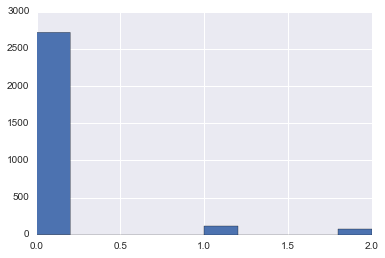

In [32]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = df[ordinal_cols].apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")

skewed_features = skewness.index
print(skewed_features)
#df_num[skewed_features] = np.log1p(df_num[skewed_features])
df_num[skewed_features[0]].hist()

In [33]:
df_num[skewed_features] = np.log1p(df_num[skewed_features])

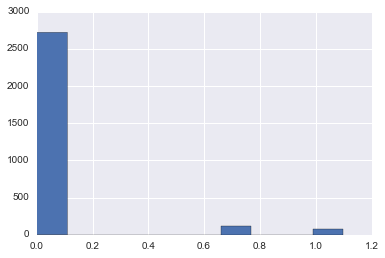

In [34]:
df_num[skewed_features[0]].hist()

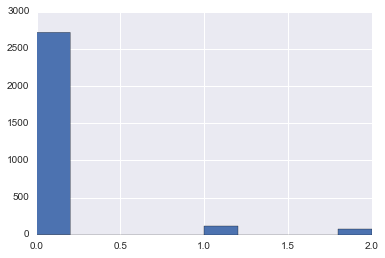

In [35]:
df[skewed_features[0]].hist()

The order is still preserved, but the difference in values is reduced for high values, which we don't want to do for ordinal values.

In [36]:
skew_cols = [col for col in df_num.columns if col not in ordinal_cols]
print(df_num.columns)
print(skew_cols)
print(ordinal_cols)

Index(['Id', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'MiscVal', 'YrSold'],
      dtype='object')
['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 

Note: you will never reach 0 skewed features!

In [37]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed


skewness = df_num[skew_cols].apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")

skewed_features = skewness.index
print(skewed_features)
df_num[skewed_features] = np.log1p(df_num[skewed_features])

25 skewed numerical features to log transform
Index(['LotArea', 'OverallCond', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal'],
      dtype='object')


## Scaling the numerical features

Check some ordinals before transformations

In [38]:
for col in ordinal_cols:
    print(df_num[col].describe())

count    2919.000000
mean        0.057852
std         0.220619
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.098612
Name: Alley, dtype: float64
count    2919.000000
mean        1.345240
std         0.241194
min         0.000000
25%         1.386294
50%         1.386294
75%         1.386294
max         1.609438
Name: BsmtCond, dtype: float64
count    2919.000000
mean        0.345152
std         0.524261
min         0.000000
25%         0.000000
50%         0.000000
75%         0.693147
max         1.386294
Name: BsmtExposure, dtype: float64
count    2919.000000
mean        3.541624
std         2.113851
min         0.000000
25%         1.000000
50%         4.000000
75%         6.000000
max         6.000000
Name: BsmtFinType1, dtype: float64
count    2919.000000
mean        0.766677
std         0.298854
min         0.000000
25%         0.693147
50%         0.693147
75%         0.693147
max         1.945910
Name: BsmtFinType2, dtype: floa

In [39]:
df_num.head()

,Id,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold
0,1,65.0,9.042040,0.693147,0.0,1.386294,1.386294,1.098612,7,1.791759,...,1.098612,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,0.0,2008
1,2,80.0,9.169623,0.693147,0.0,1.386294,1.386294,1.098612,6,2.197225,...,1.098612,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,2007
2,3,68.0,9.328212,0.693147,0.0,1.098612,1.386294,1.098612,7,1.791759,...,1.098612,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,0.0,2008
3,4,60.0,9.164401,0.693147,0.0,1.098612,1.386294,1.098612,7,1.791759,...,1.098612,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,0.0,2006
4,5,84.0,9.565284,0.693147,0.0,1.098612,1.386294,1.098612,8,1.791759,...,1.098612,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,0.0,2008


In [40]:
scaler = StandardScaler()
# The next two are wrong because they give 1D array while the scaler expects 2D, a row for each measurement
#s = scaler.fit_transform(df_num["LotFrontage"])
#s = scaler.fit_transform(df_num["LotFrontage"].values)
s = scaler.fit_transform(df_num[["LotFrontage"]])
#s = scaler.fit_transform([df_num["LotFrontage"].values])# This one is wrong because it will give ALL the entries as one entry
s
#df_num[["LotFrontage"]]
#[df_num["LotFrontage"].values]

array([[ 0.21607482],
       [ 0.66415837],
       [ 0.30569153],
       ..., 
       [ 3.05393729],
       [ 0.12645811],
       [ 0.48492495]])

In [41]:
scaler = StandardScaler()
d = df_num
for col in df_num.columns:
    d[col] = scaler.fit_transform(df_num[[col]])

With StandardScaler we get range [-1,1]. This is not exactly what we want, because we don't have negatives. All what we want is to scale in the range [0,1].

For that, we have to use MinMaxScaler instead:
    
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (max - min) + min
    


In [42]:
d.head()

,Id,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold
0,-1.731458,0.216075,-0.103719,0.064249,-0.26227,0.639430,0.018512,0.204246,0.646183,-0.435439,...,0.308888,-0.945126,0.832979,-0.427545,-0.112774,-0.309144,-0.066702,-0.056847,-0.189329,0.157646
1,-1.730271,0.664158,0.146544,0.064249,-0.26227,0.639430,0.018512,0.204246,-0.063185,1.906370,...,0.308888,1.254212,-1.083169,-0.427545,-0.112774,-0.309144,-0.066702,-0.056847,-0.189329,-0.602962
2,-1.729084,0.305692,0.457629,0.064249,-0.26227,-0.880249,0.018512,0.204246,0.646183,-0.435439,...,0.308888,-0.945126,0.663083,-0.427545,-0.112774,-0.309144,-0.066702,-0.056847,-0.189329,0.157646
3,-1.727897,0.066714,0.136301,0.064249,-0.26227,-0.880249,0.018512,0.204246,0.646183,-0.435439,...,0.308888,-0.945126,0.580589,2.738802,-0.112774,-0.309144,-0.066702,-0.056847,-0.189329,-1.363569
4,-1.726711,0.783647,0.922662,0.064249,-0.26227,-0.880249,0.018512,0.204246,1.355551,-0.435439,...,0.308888,1.085318,0.979467,-0.427545,-0.112774,-0.309144,-0.066702,-0.056847,-0.189329,0.157646


In [43]:
del d

In [44]:
scaler = MinMaxScaler()
for col in df_num.columns:
    df_num[col] = scaler.fit_transform(df_num[[col]])

In [45]:
df_num.head()

,Id,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold
0,0.000000,0.207668,0.366271,1.0,0.0,1.000000,1.0,1.0,0.666667,0.682606,...,1.0,0.000000,0.624312,0.000000,0.0,0.0,0.0,0.0,0.0,0.50
1,0.000343,0.255591,0.391245,1.0,0.0,1.000000,1.0,1.0,0.555556,0.934536,...,1.0,0.784977,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.25
2,0.000685,0.217252,0.422289,1.0,0.0,0.792481,1.0,1.0,0.666667,0.682606,...,1.0,0.000000,0.568957,0.000000,0.0,0.0,0.0,0.0,0.0,0.50
3,0.001028,0.191693,0.390223,1.0,0.0,0.792481,1.0,1.0,0.666667,0.682606,...,1.0,0.000000,0.542079,0.810539,0.0,0.0,0.0,0.0,0.0,0.00
4,0.001371,0.268371,0.468694,1.0,0.0,0.792481,1.0,1.0,0.777778,0.682606,...,1.0,0.724696,0.672040,0.000000,0.0,0.0,0.0,0.0,0.0,0.50


Check some ordinals after transformations

In [46]:
for col in ordinal_cols:
    print(df_num[col].describe())

count    2919.000000
mean        0.052659
std         0.200816
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Alley, dtype: float64
count    2919.000000
mean        0.835845
std         0.149862
min         0.000000
25%         0.861353
50%         0.861353
75%         0.861353
max         1.000000
Name: BsmtCond, dtype: float64
count    2919.000000
mean        0.248975
std         0.378175
min         0.000000
25%         0.000000
50%         0.000000
75%         0.500000
max         1.000000
Name: BsmtExposure, dtype: float64
count    2919.000000
mean        0.590271
std         0.352309
min         0.000000
25%         0.166667
50%         0.666667
75%         1.000000
max         1.000000
Name: BsmtFinType1, dtype: float64
count    2919.000000
mean        0.393994
std         0.153581
min         0.000000
25%         0.356207
50%         0.356207
75%         0.356207
max         1.000000
Name: BsmtFinType2, dtype: floa

# Categorial encoding as OHE

In [47]:
print(df.shape)
df_cat = pd.get_dummies(df_cat)
print(df_cat.shape)# Extra colmns due to extra encoding 1-col per category


(2919, 80)
(2919, 206)


## Merge numerical and categorial colomns again

In [48]:
#df = pd.concat([df_num, df_cat], axis = 1)
#df.shape

# Model NN on numerical features

In [49]:
df = df_num
df.shape

(2919, 55)

## Re-split train and test data

In [50]:
X = train_df = df[:train_idx]
X_test = test_df = df[train_idx:]
print(train_df.shape)
print(test_df.shape)

(1460, 55)
(1459, 55)


## Train/Val split

In [51]:
X_train, X_val, Y_train, Y_val = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25)
print(X.shape)
print(y.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(1460, 55)
(1460,)
(1095, 55)
(1095,)
(365, 55)
(365,)


In [52]:


model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
# Add silent=True to avoid printing out updates with each cycle
model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)], verbose=True, early_stopping_rounds=5)
model_xgb = model

[0]	validation_0-rmse:10.9389
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:10.3922
[2]	validation_0-rmse:9.87273
[3]	validation_0-rmse:9.37929
[4]	validation_0-rmse:8.91054
[5]	validation_0-rmse:8.46526
[6]	validation_0-rmse:8.04273
[7]	validation_0-rmse:7.64131
[8]	validation_0-rmse:7.25996
[9]	validation_0-rmse:6.89781
[10]	validation_0-rmse:6.55363
[11]	validation_0-rmse:6.22682
[12]	validation_0-rmse:5.91633
[13]	validation_0-rmse:5.62125
[14]	validation_0-rmse:5.34108
[15]	validation_0-rmse:5.07521
[16]	validation_0-rmse:4.8223
[17]	validation_0-rmse:4.58234
[18]	validation_0-rmse:4.35438
[19]	validation_0-rmse:4.13737
[20]	validation_0-rmse:3.93081
[21]	validation_0-rmse:3.73529
[22]	validation_0-rmse:3.54895
[23]	validation_0-rmse:3.37254
[24]	validation_0-rmse:3.20512
[25]	validation_0-rmse:3.04648
[26]	validation_0-rmse:2.89514
[27]	validation_0-rmse:2.75067
[28]	validation_0-rmse:2.61476
[29]	validation_0-rmse:2.48512
[30]	validation_0

# Evaluate

In [53]:
# make predictions
predictions = model.predict(X_val)


print("Mean Absolute Error : " + str(mean_absolute_error(predictions, Y_val)))
print("Mean Squared Error : " + str(mean_squared_error(predictions, Y_val)))
print("Root Mean Squared Error : " + str(np.sqrt(mean_squared_error(predictions, Y_val))))

Mean Absolute Error : 0.0895994885109
Mean Squared Error : 0.0181202997177
Root Mean Squared Error : 0.134611662636


# Submit

In [54]:
# Model aggregation
predictions = agg.predict(X_test.as_matrix())

NameError: name 'agg' is not defined

In [ ]:
predicted_prices = np.expm1(predictions)

In [ ]:
my_submission = pd.DataFrame({'Id': test_df.Id, 'SalePrice': predicted_prices})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)


